# Introduction
The NBA is one of the most stats heavy professional sport league in the world. The teams invest highly in analytics and tracking of different metrics, which results in a bunch of different available stats. One fan favorite statistic is the publication of the NBA 2k ratings at the beginning of each season for the eponymous video game. While only relevant for the video game itself, the ratings tend to be heavily discussed by fans and TV. But how accurate are these ratings in hindsight with respect to advanced stats, and to add something extra to this project, to salary. We want to look at the NBA 2k 2020 players stats and analyze them using the stats from the subsequent season. 
To reiterate the main question of this project was:

**Given advanced stats and salaries are NBA players matching their NBA 2k rating published prior to the season.**

# Methods & Preprocessing

## First data set
Firstly we need as many stats as possible for our players. They were combined in the second dataset from the project plan, named 1991-2021 NBA Stats from Kaggle.
Since the NBA 2k ratings were for the 2020 version of the game, only the stats for that year were needed. So every row, where the "Year" column was different to 2020 was dropped. This resulted in 484 rows of player data containing different stats like efficiency, points scored or assists. Additionally, there were uninteresting columns like Teams or Age. Since they are unimportant for analysis, but not factually incorrect or missing, they were kept in the dataset and were only removed for the analysis part. 

## Second data set
The other dataset contains the NBA 2k ratings for each player and their respective salary and game version. There were other columns containing information like colleges, jerseys or birthdays. They were all dropped in the preprocessing part. The dataset contains the ratings for 2020 and some updated ratings for picked players from 2021 or 2022. Since the stats for the 2020 season are used and duplicates have to be eliminated, every row containing a rating not from the 2020 version was dropped. That also eliminated duplicates for players, e.g. LeBron James had three entries for versions 2020, 2021 and 2022. This resulted in 429 rows of NBA 2k data. 

## Pipeline and next steps
This means there is a discrepancy between both datasets in regard to covered players. Dealing with that is the job of the analysis workflow, which is further discussed in the results chapter

Since both datasets are from Kaggle the pipeline uses the Python API for Kaggle. This makes downloading the datasets very easy, however an authentication token is necessary. This requires a free account at Kaggle.

The setup script itself uses the Kaggle API for download, does the outlined preprocessing steps and then saves the data frames in a SQLite database. 

### Interim stage
To prepare the results, we quickly check for dependencies and run our setup pipeline

In [11]:
%%capture

# Dependencies
%pip install -r project_requirements.txt     

In [2]:
import setup
setup.workflow()

Authenticated using kaggle.json
Saving the table stats_2k in database main_db.sqlite at sqlite:///../data/main_db.sqlite
Saving the table stats_player in database main_db.sqlite at sqlite:///../data/main_db.sqlite


Results: Presents the data in a fitting format (e.g., tables, diagrams, figures or similar) without interpretation

# Results

## Set up the dataframe

As discussed in the methods' chapter we need to deal with the discrepancy between the two data sets. To avoid missing data the datasets where combined and only players, which appear in both datasets are considered for analysis. The join was done on the full name of the players.

To get appropriate ratings for a player we train a Logistic Regression model using Scikit-learn. Since the evaluated player should not be in the training set and training a model for every player is rather cumbersome, we split the dataset into four groups and train a regression model on each of them. 
We then evaluate players from group A using the average of the model output from group B, C and D and so on. 

The evaluated ratings are then added as a new column into our original dataset and returned by the analysis workflow. 

It is of course important to note, that ratings and the names of players were removed from the training set before fitting the model. 

In [3]:
import matplotlib.pyplot as plt

import analysis_workflow

unified_dataframe, models = analysis_workflow.main_workflow()

Let's take a look at the final data frame:
Quick sidenote: Since the players are shuffled every run to avoid groupings present in the original dataset, the shown output will differ every run. 

In [4]:
unified_dataframe.head()

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TRB,AST,STL,BLK,TOV,PF,PTS,salary,rating,Appr. Rating
0,Eric Gordon,36.0,28.2,4.8,12.9,0.369,2.7,8.4,0.317,2.1,...,2.0,1.5,0.6,0.4,1.2,1.9,14.4,14.058,78,83.0
1,Hassan Whiteside,67.0,30.0,6.5,10.5,0.621,0.1,0.1,0.571,6.4,...,13.5,1.2,0.4,2.9,1.8,2.9,15.5,27.093,81,81.0
2,Solomon Hill,59.0,18.4,1.9,4.7,0.396,1.1,2.9,0.368,0.8,...,2.8,1.8,0.7,0.2,0.9,1.4,5.5,13.290,70,74.0
3,Miye Oni,10.0,10.9,1.2,3.2,0.375,0.7,1.9,0.368,0.5,...,1.7,0.4,0.4,0.2,0.4,0.9,3.5,0.898,69,72.0
4,Dewayne Dedmon,44.0,17.6,2.3,5.8,0.400,0.5,2.4,0.206,1.8,...,5.7,0.5,0.6,0.9,1.3,3.0,5.8,13.333,76,77.0


## First results

We can see the calculated rating in the last column "Appr. Rating". Let's compare the deviation from the actual rating for the players by adding a difference column:

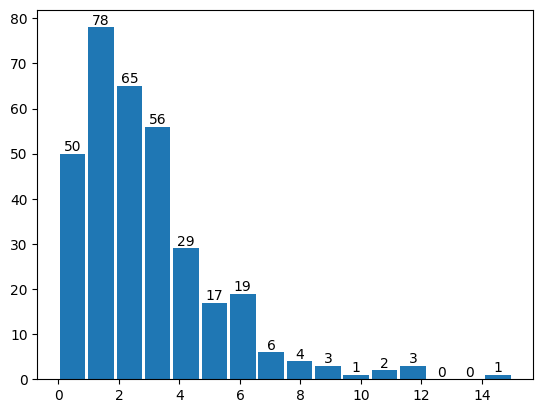

In [5]:
unified_dataframe['diff'] = (unified_dataframe['rating'] - unified_dataframe['Appr. Rating']).abs()

counts, edges, bars = plt.hist(unified_dataframe['diff'], bins = int(unified_dataframe['diff'].max())+1, rwidth=0.9) 
plt.bar_label(bars)
plt.show()

Most of the players seem to be accurately classified, if we assume correct rating for differences under or equal three. \
Let's take a closer look at the remaining players, beginning with the average rating and salary in comparison.

In [6]:
deviants = unified_dataframe.loc[unified_dataframe['diff'] > 3]

print(f"Mean rating for all players: {round(unified_dataframe['rating'].mean(), 2)}")
print(f"Mean rating for players with a rating difference larger than three: {round(deviants['rating'].mean(), 2)}M") 
print(" ")
print(f"Mean salary for all players: {round(unified_dataframe['salary'].mean(), 2)}")
print(f"Mean salary for players with a rating difference larger than three: {round(deviants['salary'].mean(), 2)}M")

Mean rating for all players: 76.46
Mean rating for players with a rating difference larger than three: 79.48M
 
Mean salary for all players: 8.73
Mean salary for players with a rating difference larger than three: 12.63M


Before we draw any conclusions, let's take a look at the deviations without computing the absolute values. We do that to check, if players get rather over or underrated by our algorithm.

In [7]:
actual_difference = (unified_dataframe['rating'] - unified_dataframe['Appr. Rating'])
print(f"The sum over the differences is: {actual_difference.sum()} for {len(actual_difference)} entries -> {round(actual_difference.sum() / len(actual_difference), 2)} per row")


The sum over the differences is: 79.0 for 334 entries -> 0.24 per row


The algorithm seem to neither heavily under nor overrate the players. Finally, let's take a look at the importance of the different features, e.g. for the first model

In [8]:
columns = list(unified_dataframe.columns)
columns.remove('Player')
columns.remove('rating')
columns.remove('Appr. Rating')
columns.remove('diff')

<Axes: ylabel='Feature'>

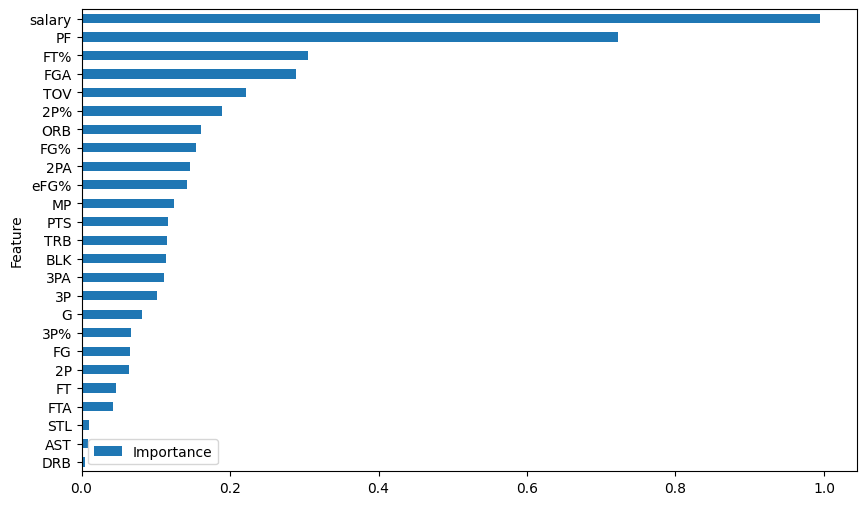

In [10]:
import pandas as pd
import numpy as np

coefficients = models[0].coef_[0]

feature_importance = pd.DataFrame({'Feature': columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Salary seems to be a very important feature, which aligns with our desired output. However, PF (=Personal fouls) as the second most important feature seems not good. Additionally, AST (assists) is one of the most important stats and has the second-lowest importance for our model. Here some future work is needed.

# Discussion

## First conclusion
It seems that higher rated player with a big salary tend to be further away from their actual rating than lower rated ones. However, the connection is of course obvious, because better players get paid more.

One possible explanation could be the trend to rate some players higher to also populate the top of the rating list. The number of players rated 90 or higher in NBA2k grew over the years. This suggests rating inflation in contrast to a higher number of players actually playing on that level in comparison to the rest of the league.

## Further work
Improve the regression by providing additional data from previous seasons. This should just require additional 2k datasets, since the stats are already present in the existing dataset. However, take the results with a grain of salt, since there are changes in the way ratings are assigned and more modern ratings tend to be higher. This can of course change the results of the regression model. Additionally, the salary cap is increasing most years, which also results in higher salaries. To avoid skewing the classification it would be possible to use the percentage of the salary cap the player is earning. This should be a fair comparison at least for the last 10 years, because the structure of allowed contracts did not change drastically except for Super Max contracts. \

As discussed in the feature importance part, some features do not correlate with their real-world importance. Removing for example personal fouls and running the experiment again could provide further insight. 